In [1]:
trial_number_ml = "003"
random_state_init = 333

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 15:26:30,425] A new study created in memory with name: no-name-48dc69b0-3c77-40a7-8244-efb1528e0d78


[I 2024-05-01 15:27:25,558] Trial 0 finished with value: 0.6200205203222301 and parameters: {'n_estimators': 345, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6200205203222301.


[I 2024-05-01 15:27:41,421] Trial 1 finished with value: 0.622890317861823 and parameters: {'n_estimators': 345, 'max_depth': 87, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.622890317861823.


[I 2024-05-01 15:28:15,196] Trial 3 finished with value: 0.6209708550472882 and parameters: {'n_estimators': 597, 'max_depth': 51, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.622890317861823.


[I 2024-05-01 15:29:04,856] Trial 2 finished with value: 0.6238543666636189 and parameters: {'n_estimators': 756, 'max_depth': 69, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.6238543666636189.


[I 2024-05-01 15:29:13,052] Trial 4 finished with value: 0.6225738782393158 and parameters: {'n_estimators': 451, 'max_depth': 99, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6238543666636189.


[I 2024-05-01 15:29:29,044] Trial 5 finished with value: 0.6286253415820966 and parameters: {'n_estimators': 556, 'max_depth': 45, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6286253415820966.


[I 2024-05-01 15:29:43,629] Trial 6 finished with value: 0.6232032019829539 and parameters: {'n_estimators': 634, 'max_depth': 65, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 5 with value: 0.6286253415820966.


[I 2024-05-01 15:30:00,348] Trial 9 finished with value: 0.6273499324454739 and parameters: {'n_estimators': 189, 'max_depth': 52, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6286253415820966.


[I 2024-05-01 15:30:03,807] Trial 10 pruned. 


[I 2024-05-01 15:30:13,301] Trial 11 pruned. 


[I 2024-05-01 15:30:38,089] Trial 13 pruned. 


[I 2024-05-01 15:30:41,956] Trial 14 pruned. 


[I 2024-05-01 15:30:49,015] Trial 15 pruned. 


[I 2024-05-01 15:30:53,827] Trial 7 finished with value: 0.6241642032121415 and parameters: {'n_estimators': 717, 'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6286253415820966.


[I 2024-05-01 15:31:02,272] Trial 8 finished with value: 0.6257575757575757 and parameters: {'n_estimators': 704, 'max_depth': 90, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.6286253415820966.


[I 2024-05-01 15:31:20,284] Trial 18 pruned. 


[I 2024-05-01 15:31:23,920] Trial 12 finished with value: 0.6286278812259368 and parameters: {'n_estimators': 492, 'max_depth': 32, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6286278812259368.


[I 2024-05-01 15:31:43,449] Trial 20 pruned. 


[I 2024-05-01 15:31:53,090] Trial 17 pruned. 


[I 2024-05-01 15:32:30,325] Trial 16 finished with value: 0.6257570678288076 and parameters: {'n_estimators': 448, 'max_depth': 56, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.6286278812259368.


[I 2024-05-01 15:32:32,446] Trial 19 finished with value: 0.630220745842603 and parameters: {'n_estimators': 287, 'max_depth': 30, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.630220745842603.


[I 2024-05-01 15:32:45,386] Trial 23 pruned. 


[I 2024-05-01 15:33:01,801] Trial 21 finished with value: 0.6292653318298642 and parameters: {'n_estimators': 331, 'max_depth': 31, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.630220745842603.


[I 2024-05-01 15:33:12,979] Trial 26 pruned. 


[I 2024-05-01 15:33:13,028] Trial 22 finished with value: 0.6232098050569388 and parameters: {'n_estimators': 344, 'max_depth': 34, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.630220745842603.


[I 2024-05-01 15:33:23,440] Trial 28 pruned. 


[I 2024-05-01 15:33:28,242] Trial 29 pruned. 


[I 2024-05-01 15:33:38,475] Trial 24 finished with value: 0.6263935025751989 and parameters: {'n_estimators': 305, 'max_depth': 31, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.630220745842603.


[I 2024-05-01 15:33:40,474] Trial 25 finished with value: 0.6241626794258373 and parameters: {'n_estimators': 277, 'max_depth': 22, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.630220745842603.


[I 2024-05-01 15:33:44,300] Trial 30 pruned. 


[I 2024-05-01 15:33:55,250] Trial 31 pruned. 


[I 2024-05-01 15:33:56,367] Trial 32 pruned. 


[I 2024-05-01 15:34:04,938] Trial 27 finished with value: 0.6311786994991821 and parameters: {'n_estimators': 246, 'max_depth': 37, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6311786994991821.


[I 2024-05-01 15:34:13,105] Trial 36 pruned. 


[I 2024-05-01 15:34:15,912] Trial 34 pruned. 


[I 2024-05-01 15:34:18,232] Trial 35 pruned. 


[I 2024-05-01 15:34:22,644] Trial 38 pruned. 


[I 2024-05-01 15:34:25,284] Trial 39 pruned. 


[I 2024-05-01 15:34:26,070] Trial 37 pruned. 


[I 2024-05-01 15:34:34,849] Trial 40 pruned. 


[I 2024-05-01 15:34:41,429] Trial 41 pruned. 


[I 2024-05-01 15:34:41,819] Trial 42 pruned. 


[I 2024-05-01 15:34:42,134] Trial 43 pruned. 


[I 2024-05-01 15:34:49,536] Trial 44 pruned. 


[I 2024-05-01 15:35:06,251] Trial 33 finished with value: 0.6302237934152115 and parameters: {'n_estimators': 391, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 27 with value: 0.6311786994991821.


[I 2024-05-01 15:35:10,440] Trial 45 pruned. 


[I 2024-05-01 15:35:10,640] Trial 46 pruned. 


[I 2024-05-01 15:35:15,302] Trial 47 pruned. 


[I 2024-05-01 15:35:17,982] Trial 49 pruned. 


[I 2024-05-01 15:35:19,500] Trial 48 pruned. 


Best trial for RandomForestClassifier:
  Value: 0.6311786994991821
  Params: 
    n_estimators: 246
    max_depth: 37
    min_samples_split: 18
    min_samples_leaf: 4
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 246, 'max_depth': 37, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


[I 2024-05-01 15:35:23,742] A new study created in memory with name: no-name-9c34a130-1058-4b44-9774-548eb6f10378


RandomForestClassifier accuracy: 0.6255



[I 2024-05-01 15:36:10,582] Trial 1 finished with value: 0.6082370808317841 and parameters: {'n_estimators': 314, 'max_depth': 9, 'learning_rate': 0.18621504579235917, 'min_child_weight': 4, 'subsample': 0.854100633727773, 'colsample_bytree': 0.5825292863875529, 'gamma': 0.06271486875461196, 'reg_lambda': 0.010526831261672144, 'reg_alpha': 0.016055124793056288}. Best is trial 1 with value: 0.6082370808317841.


[I 2024-05-01 15:36:15,808] Trial 3 finished with value: 0.6088679283617265 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.10588526341476581, 'min_child_weight': 4, 'subsample': 0.9807417306851954, 'colsample_bytree': 0.8323551438570144, 'gamma': 0.2364841206737256, 'reg_lambda': 0.1118033839136068, 'reg_alpha': 0.016293181660480476}. Best is trial 3 with value: 0.6088679283617265.


[I 2024-05-01 15:36:21,158] Trial 2 finished with value: 0.6088653887178863 and parameters: {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.17901758504968376, 'min_child_weight': 2, 'subsample': 0.6899108260513515, 'colsample_bytree': 0.8091896817087131, 'gamma': 2.280714186045107, 'reg_lambda': 1.4122874356709763, 'reg_alpha': 5.700403860032376}. Best is trial 3 with value: 0.6088679283617265.


[I 2024-05-01 15:36:24,286] Trial 0 finished with value: 0.5941979296823414 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.16520151999007404, 'min_child_weight': 10, 'subsample': 0.5438301226543747, 'colsample_bytree': 0.7153176120412248, 'gamma': 1.910059206632686, 'reg_lambda': 4.247564901127778, 'reg_alpha': 0.05560568293316564}. Best is trial 3 with value: 0.6088679283617265.


[I 2024-05-01 15:36:30,849] Trial 4 finished with value: 0.6021719034122655 and parameters: {'n_estimators': 232, 'max_depth': 5, 'learning_rate': 0.23631842923513796, 'min_child_weight': 3, 'subsample': 0.9215421878482707, 'colsample_bytree': 0.5456056190538683, 'gamma': 2.677655097470309, 'reg_lambda': 0.31239392149982753, 'reg_alpha': 0.010923033987845233}. Best is trial 3 with value: 0.6088679283617265.


[I 2024-05-01 15:36:39,732] Trial 6 pruned. 


[I 2024-05-01 15:36:49,231] Trial 9 pruned. 


[I 2024-05-01 15:37:04,937] Trial 10 finished with value: 0.619384593504607 and parameters: {'n_estimators': 191, 'max_depth': 7, 'learning_rate': 0.1848190927394488, 'min_child_weight': 8, 'subsample': 0.9342336892527596, 'colsample_bytree': 0.7331249565243708, 'gamma': 2.322593063382714, 'reg_lambda': 0.32040386299817925, 'reg_alpha': 3.5706047820610145}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:37:05,170] Trial 5 finished with value: 0.6047186582553663 and parameters: {'n_estimators': 234, 'max_depth': 10, 'learning_rate': 0.09742896552560504, 'min_child_weight': 7, 'subsample': 0.5001149821733849, 'colsample_bytree': 0.7853566810134399, 'gamma': 0.7910965143715393, 'reg_lambda': 0.2953377794992223, 'reg_alpha': 0.21017817411155562}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:37:07,909] Trial 7 finished with value: 0.6171542782840134 and parameters: {'n_estimators': 434, 'max_depth': 5, 'learning_rate': 0.05225405147665405, 'min_child_weight': 7, 'subsample': 0.8633443151617544, 'colsample_bytree': 0.8656260963260103, 'gamma': 3.9216127801388314, 'reg_lambda': 5.041766945715202, 'reg_alpha': 0.06061368498817354}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:37:19,587] Trial 13 finished with value: 0.6059915277481485 and parameters: {'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.276201082740211, 'min_child_weight': 8, 'subsample': 0.7488999190527306, 'colsample_bytree': 0.9989329099935454, 'gamma': 4.72385014625505, 'reg_lambda': 0.022304329485045373, 'reg_alpha': 1.7164748644874455}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:37:31,852] Trial 14 pruned. 


[I 2024-05-01 15:37:36,514] Trial 15 pruned. 


[I 2024-05-01 15:38:01,887] Trial 8 finished with value: 0.6133290667316815 and parameters: {'n_estimators': 811, 'max_depth': 5, 'learning_rate': 0.04758564254826618, 'min_child_weight': 2, 'subsample': 0.6206440349005818, 'colsample_bytree': 0.9190145448691913, 'gamma': 2.8313260298153993, 'reg_lambda': 1.4474528006653868, 'reg_alpha': 0.09161762362011579}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:16,470] Trial 12 pruned. 


[I 2024-05-01 15:38:18,281] Trial 11 finished with value: 0.6082233667550463 and parameters: {'n_estimators': 538, 'max_depth': 5, 'learning_rate': 0.012733258425544253, 'min_child_weight': 6, 'subsample': 0.5224910455612755, 'colsample_bytree': 0.942922653385339, 'gamma': 0.1375512903326076, 'reg_lambda': 1.5164209703982623, 'reg_alpha': 0.02310353276456246}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:29,752] Trial 16 finished with value: 0.6187517142595922 and parameters: {'n_estimators': 560, 'max_depth': 8, 'learning_rate': 0.10193290492135869, 'min_child_weight': 6, 'subsample': 0.9500198136759368, 'colsample_bytree': 0.6613827880431431, 'gamma': 1.5015174591442735, 'reg_lambda': 1.1279270877099747, 'reg_alpha': 0.08854829876151837}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:32,456] Trial 18 finished with value: 0.5996139741362672 and parameters: {'n_estimators': 151, 'max_depth': 3, 'learning_rate': 0.13012420875785458, 'min_child_weight': 6, 'subsample': 0.998380470204874, 'colsample_bytree': 0.6806918402968754, 'gamma': 1.6885364099955182, 'reg_lambda': 0.046051121230820086, 'reg_alpha': 9.96871183710339}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:37,953] Trial 19 finished with value: 0.6181066447241439 and parameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.12187474971509202, 'min_child_weight': 6, 'subsample': 0.9978898667208473, 'colsample_bytree': 0.6523190743984645, 'gamma': 1.6070699222985523, 'reg_lambda': 0.06689557165951557, 'reg_alpha': 0.288591203349794}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:44,529] Trial 17 finished with value: 0.6155659850262599 and parameters: {'n_estimators': 514, 'max_depth': 8, 'learning_rate': 0.11722127270625632, 'min_child_weight': 6, 'subsample': 0.9805903754999439, 'colsample_bytree': 0.6408932296998394, 'gamma': 1.4174683636703087, 'reg_lambda': 0.06129521900486395, 'reg_alpha': 1.581195139087908}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:48,550] Trial 21 pruned. 


[I 2024-05-01 15:38:50,908] Trial 20 finished with value: 0.6171542782840135 and parameters: {'n_estimators': 149, 'max_depth': 8, 'learning_rate': 0.12857036379039993, 'min_child_weight': 5, 'subsample': 0.9689461119449105, 'colsample_bytree': 0.6660450255936479, 'gamma': 1.4603482903048237, 'reg_lambda': 0.6924048203915082, 'reg_alpha': 0.2770734150749857}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:38:54,800] Trial 22 pruned. 


[I 2024-05-01 15:39:08,777] Trial 24 finished with value: 0.6190656142382591 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.13550070576272527, 'min_child_weight': 8, 'subsample': 0.9095925310213248, 'colsample_bytree': 0.7324934542152923, 'gamma': 2.1715683402767096, 'reg_lambda': 0.6732633162736974, 'reg_alpha': 0.13051899466142303}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:39:17,591] Trial 26 finished with value: 0.6168347910888977 and parameters: {'n_estimators': 185, 'max_depth': 7, 'learning_rate': 0.14789201182192419, 'min_child_weight': 9, 'subsample': 0.7983391426341313, 'colsample_bytree': 0.7451339841862586, 'gamma': 2.1063736748663007, 'reg_lambda': 0.05293968893036294, 'reg_alpha': 0.14383086088450173}. Best is trial 10 with value: 0.619384593504607.


[I 2024-05-01 15:39:20,387] Trial 25 finished with value: 0.6200195044646939 and parameters: {'n_estimators': 284, 'max_depth': 7, 'learning_rate': 0.1442028338613223, 'min_child_weight': 9, 'subsample': 0.9212899514077995, 'colsample_bytree': 0.7545115108043613, 'gamma': 2.175287135435809, 'reg_lambda': 0.6622458864142862, 'reg_alpha': 0.1519415704692564}. Best is trial 25 with value: 0.6200195044646939.


[I 2024-05-01 15:39:23,313] Trial 27 pruned. 


[I 2024-05-01 15:39:26,781] Trial 23 pruned. 


[I 2024-05-01 15:39:29,171] Trial 30 pruned. 


[I 2024-05-01 15:39:30,914] Trial 31 pruned. 


[I 2024-05-01 15:39:37,520] Trial 28 finished with value: 0.6161948008411301 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.07892808143984208, 'min_child_weight': 9, 'subsample': 0.8972056609505386, 'colsample_bytree': 0.7539390470823861, 'gamma': 2.497321058480018, 'reg_lambda': 0.8574797993233898, 'reg_alpha': 0.03890463306839795}. Best is trial 25 with value: 0.6200195044646939.


[I 2024-05-01 15:39:49,562] Trial 29 finished with value: 0.6114101118459148 and parameters: {'n_estimators': 314, 'max_depth': 6, 'learning_rate': 0.1513920454420921, 'min_child_weight': 9, 'subsample': 0.8970962349845076, 'colsample_bytree': 0.758194014743373, 'gamma': 2.5231632418089727, 'reg_lambda': 0.5043653421415433, 'reg_alpha': 0.037717335631868076}. Best is trial 25 with value: 0.6200195044646939.


[I 2024-05-01 15:39:53,236] Trial 33 finished with value: 0.62002052032223 and parameters: {'n_estimators': 193, 'max_depth': 10, 'learning_rate': 0.1531038021558427, 'min_child_weight': 8, 'subsample': 0.7789935384296706, 'colsample_bytree': 0.7048624166761807, 'gamma': 2.026915479721074, 'reg_lambda': 3.488386095914624, 'reg_alpha': 1.3666137942020924}. Best is trial 33 with value: 0.62002052032223.


[I 2024-05-01 15:39:57,760] Trial 34 pruned. 


[I 2024-05-01 15:40:04,171] Trial 32 finished with value: 0.6158697264295656 and parameters: {'n_estimators': 190, 'max_depth': 9, 'learning_rate': 0.07333680891799868, 'min_child_weight': 8, 'subsample': 0.8062298302320018, 'colsample_bytree': 0.7115276299363101, 'gamma': 1.9270881204588113, 'reg_lambda': 0.17053535683069634, 'reg_alpha': 1.2115283942947657}. Best is trial 33 with value: 0.62002052032223.


[I 2024-05-01 15:40:04,880] Trial 37 pruned. 


[I 2024-05-01 15:40:14,959] Trial 39 pruned. 


[I 2024-05-01 15:40:15,541] Trial 38 pruned. 


[I 2024-05-01 15:40:18,256] Trial 40 pruned. 


[I 2024-05-01 15:40:19,111] Trial 41 pruned. 


[I 2024-05-01 15:40:20,882] Trial 42 pruned. 


[I 2024-05-01 15:40:21,055] Trial 36 finished with value: 0.6206523837097085 and parameters: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.18671154169885654, 'min_child_weight': 8, 'subsample': 0.7981725416416292, 'colsample_bytree': 0.702397072081572, 'gamma': 1.9795766715466507, 'reg_lambda': 4.320617468676827, 'reg_alpha': 1.80608364791866}. Best is trial 36 with value: 0.6206523837097085.


[I 2024-05-01 15:40:21,969] Trial 35 finished with value: 0.620018996535926 and parameters: {'n_estimators': 188, 'max_depth': 9, 'learning_rate': 0.08622671626717197, 'min_child_weight': 8, 'subsample': 0.9537801675492177, 'colsample_bytree': 0.710038337813762, 'gamma': 1.9778844602534966, 'reg_lambda': 2.92448958817005, 'reg_alpha': 0.12464386132957983}. Best is trial 36 with value: 0.6206523837097085.


[I 2024-05-01 15:40:23,703] Trial 46 pruned. 


[I 2024-05-01 15:40:23,862] Trial 45 pruned. 


[I 2024-05-01 15:40:24,621] Trial 44 pruned. 


[I 2024-05-01 15:40:25,424] Trial 48 pruned. 


[I 2024-05-01 15:40:25,568] Trial 47 pruned. 


[I 2024-05-01 15:40:26,226] Trial 49 pruned. 


[I 2024-05-01 15:40:27,673] Trial 43 finished with value: 0.6181117240118246 and parameters: {'n_estimators': 127, 'max_depth': 9, 'learning_rate': 0.13732918744287126, 'min_child_weight': 8, 'subsample': 0.8274989304185588, 'colsample_bytree': 0.8603537429768278, 'gamma': 0.6306627465574248, 'reg_lambda': 2.417160288620921, 'reg_alpha': 0.4923172142788888}. Best is trial 36 with value: 0.6206523837097085.


Best trial for XGBClassifier:
  Value: 0.6206523837097085
  Params: 
    n_estimators: 253
    max_depth: 9
    learning_rate: 0.18671154169885654
    min_child_weight: 8
    subsample: 0.7981725416416292
    colsample_bytree: 0.702397072081572
    gamma: 1.9795766715466507
    reg_lambda: 4.320617468676827
    reg_alpha: 1.80608364791866

Best hyperparameters for XGBClassifier: {'n_estimators': 253, 'max_depth': 9, 'learning_rate': 0.18671154169885654, 'min_child_weight': 8, 'subsample': 0.7981725416416292, 'colsample_bytree': 0.702397072081572, 'gamma': 1.9795766715466507, 'reg_lambda': 4.320617468676827, 'reg_alpha': 1.80608364791866}


[I 2024-05-01 15:41:08,031] A new study created in memory with name: no-name-b527e568-c0fd-4f30-b1fe-8bf2cdd47572


XGBClassifier accuracy: 0.6140



[I 2024-05-01 15:41:08,763] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 72, 'max_depth': -1, 'learning_rate': 0.006242174502882197, 'n_estimators': 162, 'min_child_weight': 0.0011225563010426784, 'min_child_samples': 1945, 'subsample': 0.8397656657159493, 'colsample_bytree': 0.8880020367991414, 'reg_alpha': 1.628910443927747e-09, 'reg_lambda': 0.7435021717759884}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:41:08,863] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'max_depth': 6, 'learning_rate': 0.10578726750285725, 'n_estimators': 399, 'min_child_weight': 0.00620506384827569, 'min_child_samples': 1443, 'subsample': 0.8767081481716764, 'colsample_bytree': 0.9157214357973115, 'reg_alpha': 0.00014875138100641067, 'reg_lambda': 1.3140428589890914e-07}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:41:08,940] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 12, 'learning_rate': 0.42090047540477243, 'n_estimators': 472, 'min_child_weight': 0.055415581065967195, 'min_child_samples': 1743, 'subsample': 0.8375017195579463, 'colsample_bytree': 0.8724304480186571, 'reg_alpha': 5.6554839756570367e-05, 'reg_lambda': 2.379105660425916e-09}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:41:09,370] Trial 4 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 85, 'max_depth': 5, 'learning_rate': 0.36257342192821235, 'n_estimators': 271, 'min_child_weight': 0.06646736248626207, 'min_child_samples': 1928, 'subsample': 0.9511769748643231, 'colsample_bytree': 0.9559575659136682, 'reg_alpha': 1.606187905787096e-06, 'reg_lambda': 0.01363303019419873}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:41:09,577] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': -1, 'learning_rate': 0.2439837060565508, 'n_estimators': 272, 'min_child_weight': 0.008915307355688138, 'min_child_samples': 1576, 'subsample': 0.8464540856906242, 'colsample_bytree': 0.8072756953749578, 'reg_alpha': 3.6214559670016205e-07, 'reg_lambda': 1.2756876064551534e-06}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 15:41:11,048] Trial 7 finished with value: 0.5817602779386218 and parameters: {'boosting_type': 'goss', 'num_leaves': 80, 'max_depth': 12, 'learning_rate': 0.32978972227138253, 'n_estimators': 397, 'min_child_weight': 0.04516505544334604, 'min_child_samples': 768, 'subsample': 0.9111275423719967, 'colsample_bytree': 0.9128386872014398, 'reg_alpha': 0.000970951329432894, 'reg_lambda': 0.0014783362608200006}. Best is trial 7 with value: 0.5817602779386218.


[I 2024-05-01 15:41:11,239] Trial 3 finished with value: 0.5932409918832983 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': 10, 'learning_rate': 0.06725506144198366, 'n_estimators': 352, 'min_child_weight': 0.005186606091204674, 'min_child_samples': 499, 'subsample': 0.9945560754738829, 'colsample_bytree': 0.816688050328329, 'reg_alpha': 6.018096120825931e-07, 'reg_lambda': 1.2282494153208953e-08}. Best is trial 3 with value: 0.5932409918832983.


[I 2024-05-01 15:41:13,051] Trial 10 finished with value: 0.5709165066691048 and parameters: {'boosting_type': 'goss', 'num_leaves': 35, 'max_depth': 4, 'learning_rate': 0.22919745076933468, 'n_estimators': 523, 'min_child_weight': 0.002807304166394897, 'min_child_samples': 900, 'subsample': 0.8883410520709681, 'colsample_bytree': 0.8245997655720765, 'reg_alpha': 2.083837913918892e-09, 'reg_lambda': 0.7361015358190335}. Best is trial 3 with value: 0.5932409918832983.


[I 2024-05-01 15:41:13,182] Trial 8 finished with value: 0.5690117737888439 and parameters: {'boosting_type': 'dart', 'num_leaves': 75, 'max_depth': 10, 'learning_rate': 0.38494564485423266, 'n_estimators': 242, 'min_child_weight': 0.05005867078202743, 'min_child_samples': 868, 'subsample': 0.8210095547806847, 'colsample_bytree': 0.8232782138286505, 'reg_alpha': 4.131838055122914e-09, 'reg_lambda': 2.64960797547071e-06}. Best is trial 3 with value: 0.5932409918832983.


[I 2024-05-01 15:41:13,986] Trial 12 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.39598156262721396, 'n_estimators': 704, 'min_child_weight': 0.0010394586572664356, 'min_child_samples': 1300, 'subsample': 0.8841683698318143, 'colsample_bytree': 0.9988955489566875, 'reg_alpha': 0.3810850183101185, 'reg_lambda': 1.4133428498543425e-08}. Best is trial 3 with value: 0.5932409918832983.


[I 2024-05-01 15:41:15,101] Trial 11 finished with value: 0.575065776775465 and parameters: {'boosting_type': 'goss', 'num_leaves': 45, 'max_depth': 8, 'learning_rate': 0.2198323983446071, 'n_estimators': 551, 'min_child_weight': 0.0016965705561396783, 'min_child_samples': 844, 'subsample': 0.907789669962774, 'colsample_bytree': 0.9198454903547775, 'reg_alpha': 0.00015000797397233487, 'reg_lambda': 0.3480804716166826}. Best is trial 3 with value: 0.5932409918832983.


[I 2024-05-01 15:41:16,853] Trial 9 finished with value: 0.5935579394345737 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 13, 'learning_rate': 0.29735219524592765, 'n_estimators': 586, 'min_child_weight': 0.002226784209482888, 'min_child_samples': 323, 'subsample': 0.9237222476225213, 'colsample_bytree': 0.9423802798443313, 'reg_alpha': 0.0001215282423510845, 'reg_lambda': 0.012512796472074157}. Best is trial 9 with value: 0.5935579394345737.


[I 2024-05-01 15:41:17,954] Trial 6 finished with value: 0.6043915521287294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.08713769912036895, 'n_estimators': 909, 'min_child_weight': 0.019618558391093503, 'min_child_samples': 349, 'subsample': 0.8774265647254679, 'colsample_bytree': 0.8598501109294561, 'reg_alpha': 2.759125096681296e-08, 'reg_lambda': 4.1786092301280816e-10}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:19,636] Trial 15 pruned. 


[I 2024-05-01 15:41:25,309] Trial 14 finished with value: 0.5964307845467751 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'max_depth': 14, 'learning_rate': 0.12019092489825142, 'n_estimators': 975, 'min_child_weight': 0.022192306642744505, 'min_child_samples': 265, 'subsample': 0.9992003477169784, 'colsample_bytree': 0.8531969021300964, 'reg_alpha': 0.012418369254548284, 'reg_lambda': 0.0005888307545478467}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:26,101] Trial 13 finished with value: 0.5900491675047491 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 15, 'learning_rate': 0.13129005040568037, 'n_estimators': 801, 'min_child_weight': 0.003625171580075986, 'min_child_samples': 195, 'subsample': 0.9960684660894027, 'colsample_bytree': 0.8548905659601641, 'reg_alpha': 0.022400713616073858, 'reg_lambda': 3.135974373977307e-10}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:26,939] Trial 17 pruned. 


[I 2024-05-01 15:41:30,656] Trial 20 pruned. 


[I 2024-05-01 15:41:32,975] Trial 21 finished with value: 0.5594352847956602 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 2, 'learning_rate': 0.17478232430882137, 'n_estimators': 829, 'min_child_weight': 0.021222611539796543, 'min_child_samples': 1131, 'subsample': 0.9615860883147204, 'colsample_bytree': 0.8807893963503075, 'reg_alpha': 0.5331512690649124, 'reg_lambda': 2.0238894962322338e-05}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:36,525] Trial 22 finished with value: 0.5941979296823414 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 13, 'learning_rate': 0.062135321846703, 'n_estimators': 704, 'min_child_weight': 0.013942733601259603, 'min_child_samples': 548, 'subsample': 0.8604515295741413, 'colsample_bytree': 0.8392291735618647, 'reg_alpha': 7.391956419171371e-06, 'reg_lambda': 1.9727999805603483e-07}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:38,160] Trial 16 finished with value: 0.5849531181747072 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 15, 'learning_rate': 0.48936669903871227, 'n_estimators': 990, 'min_child_weight': 0.018527451297613004, 'min_child_samples': 75, 'subsample': 0.9378877280067484, 'colsample_bytree': 0.8642559413772702, 'reg_alpha': 0.029403565262449055, 'reg_lambda': 1.47094496246743e-10}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:38,519] Trial 18 pruned. 


[I 2024-05-01 15:41:41,989] Trial 24 finished with value: 0.5830351791464766 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'max_depth': 13, 'learning_rate': 0.0635896139671155, 'n_estimators': 692, 'min_child_weight': 0.01190455445552, 'min_child_samples': 502, 'subsample': 0.8603367049287146, 'colsample_bytree': 0.837863302179427, 'reg_alpha': 4.5788119598284935e-08, 'reg_lambda': 2.5090621420615585e-07}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:42,227] Trial 25 finished with value: 0.5887752821544308 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 93, 'max_depth': 13, 'learning_rate': 0.05351961524277486, 'n_estimators': 695, 'min_child_weight': 0.011515242515155304, 'min_child_samples': 491, 'subsample': 0.8674650457401947, 'colsample_bytree': 0.8376914000745846, 'reg_alpha': 5.581488681775963e-06, 'reg_lambda': 2.8020947540267633e-07}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:41:48,719] Trial 26 finished with value: 0.5973811192718333 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 72, 'max_depth': 9, 'learning_rate': 0.06363298107429852, 'n_estimators': 888, 'min_child_weight': 0.01133378546205577, 'min_child_samples': 385, 'subsample': 0.8007582245869751, 'colsample_bytree': 0.8379800482343944, 'reg_alpha': 7.5030534873723884e-06, 'reg_lambda': 5.705035910271216e-08}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:42:06,941] Trial 27 finished with value: 0.5941969138248051 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 9, 'learning_rate': 0.08788419971864135, 'n_estimators': 895, 'min_child_weight': 0.03045339242364044, 'min_child_samples': 643, 'subsample': 0.8044269274521348, 'colsample_bytree': 0.889639426367856, 'reg_alpha': 1.0456214701481885e-05, 'reg_lambda': 1.4959730741040498e-08}. Best is trial 6 with value: 0.6043915521287294.


[I 2024-05-01 15:42:08,886] Trial 29 pruned. 


[I 2024-05-01 15:42:16,742] Trial 30 finished with value: 0.6114065563445383 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 7, 'learning_rate': 0.03220575734766851, 'n_estimators': 776, 'min_child_weight': 0.03153921494034579, 'min_child_samples': 364, 'subsample': 0.9796004229737226, 'colsample_bytree': 0.8993737371149434, 'reg_alpha': 3.4662126769091527e-08, 'reg_lambda': 2.1413487865580457e-09}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:42:23,931] Trial 28 finished with value: 0.6107670740255386 and parameters: {'boosting_type': 'dart', 'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.1815980611832057, 'n_estimators': 904, 'min_child_weight': 0.03553094240767599, 'min_child_samples': 327, 'subsample': 0.8088064438295723, 'colsample_bytree': 0.8009298740961999, 'reg_alpha': 0.0010000476590092595, 'reg_lambda': 5.668726335969411e-09}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:42:28,831] Trial 32 pruned. 


[I 2024-05-01 15:42:33,533] Trial 33 pruned. 


[I 2024-05-01 15:42:41,883] Trial 19 finished with value: 0.606323205233698 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'max_depth': 10, 'learning_rate': 0.1719664385432138, 'n_estimators': 949, 'min_child_weight': 0.023022138957297263, 'min_child_samples': 30, 'subsample': 0.9617222616665344, 'colsample_bytree': 0.8492046414025552, 'reg_alpha': 7.654185947783802e-08, 'reg_lambda': 8.817258599649687e-05}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:42:44,524] Trial 31 finished with value: 0.5884603663182275 and parameters: {'boosting_type': 'dart', 'num_leaves': 74, 'max_depth': 8, 'learning_rate': 0.028537700454755593, 'n_estimators': 774, 'min_child_weight': 0.03333800013888638, 'min_child_samples': 435, 'subsample': 0.971492653405683, 'colsample_bytree': 0.8954229648674835, 'reg_alpha': 4.056064707495596e-08, 'reg_lambda': 2.0181140829978615e-09}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:42:46,649] Trial 23 finished with value: 0.6015359765946424 and parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'max_depth': 11, 'learning_rate': 0.18398626124917092, 'n_estimators': 906, 'min_child_weight': 0.03157868730291466, 'min_child_samples': 46, 'subsample': 0.8088549306898861, 'colsample_bytree': 0.8750818161821982, 'reg_alpha': 4.6419501161145204e-08, 'reg_lambda': 0.010920716787527955}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:42:52,741] Trial 37 pruned. 


[I 2024-05-01 15:42:54,307] Trial 36 pruned. 


[I 2024-05-01 15:43:07,998] Trial 34 finished with value: 0.5941943741809649 and parameters: {'boosting_type': 'dart', 'num_leaves': 78, 'max_depth': 8, 'learning_rate': 0.03310911739755289, 'n_estimators': 909, 'min_child_weight': 0.034383593231647816, 'min_child_samples': 378, 'subsample': 0.8196125226974396, 'colsample_bytree': 0.8167420149791165, 'reg_alpha': 2.3703442031961996e-07, 'reg_lambda': 3.9239182248789104e-08}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:43:18,655] Trial 35 finished with value: 0.6015232783754406 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'max_depth': 8, 'learning_rate': 0.15286904486326236, 'n_estimators': 921, 'min_child_weight': 0.03179511916301431, 'min_child_samples': 382, 'subsample': 0.9742730226062529, 'colsample_bytree': 0.9258891154426191, 'reg_alpha': 2.008492927237433e-07, 'reg_lambda': 1.133034219463418e-05}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:43:19,427] Trial 41 pruned. 


[I 2024-05-01 15:43:19,659] Trial 42 pruned. 


[I 2024-05-01 15:43:28,135] Trial 39 finished with value: 0.599933969260151 and parameters: {'boosting_type': 'dart', 'num_leaves': 39, 'max_depth': 8, 'learning_rate': 0.14478216650286357, 'n_estimators': 842, 'min_child_weight': 0.015209485694776134, 'min_child_samples': 371, 'subsample': 0.9842914919248464, 'colsample_bytree': 0.8153158600183303, 'reg_alpha': 7.653315650631143e-09, 'reg_lambda': 5.4234708720878726e-09}. Best is trial 30 with value: 0.6114065563445383.


[I 2024-05-01 15:43:32,657] Trial 38 finished with value: 0.6117290911122624 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 8, 'learning_rate': 0.1495624455734693, 'n_estimators': 935, 'min_child_weight': 0.06916733356386486, 'min_child_samples': 337, 'subsample': 0.9787473579719479, 'colsample_bytree': 0.8152075891873904, 'reg_alpha': 5.973728846241322e-10, 'reg_lambda': 1.6084082843919847e-06}. Best is trial 38 with value: 0.6117290911122624.


[I 2024-05-01 15:43:43,953] Trial 40 finished with value: 0.6040720649336138 and parameters: {'boosting_type': 'dart', 'num_leaves': 37, 'max_depth': 11, 'learning_rate': 0.14143341208993326, 'n_estimators': 851, 'min_child_weight': 0.014496888808554192, 'min_child_samples': 322, 'subsample': 0.8990015110460656, 'colsample_bytree': 0.8834896191913683, 'reg_alpha': 1.102333277702547e-06, 'reg_lambda': 6.870780839293662e-09}. Best is trial 38 with value: 0.6117290911122624.


[I 2024-05-01 15:43:45,592] Trial 44 pruned. 


[I 2024-05-01 15:43:46,469] Trial 43 finished with value: 0.5999268582573979 and parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'max_depth': 12, 'learning_rate': 0.2692459941480173, 'n_estimators': 640, 'min_child_weight': 0.007237813951965892, 'min_child_samples': 281, 'subsample': 0.8478707392224722, 'colsample_bytree': 0.8848418997221721, 'reg_alpha': 7.96942224869147e-09, 'reg_lambda': 8.820012412028953e-07}. Best is trial 38 with value: 0.6117290911122624.


[I 2024-05-01 15:43:48,298] Trial 48 finished with value: 0.5983385649996444 and parameters: {'boosting_type': 'goss', 'num_leaves': 52, 'max_depth': 5, 'learning_rate': 0.09686692254480637, 'n_estimators': 122, 'min_child_weight': 0.09814778170657278, 'min_child_samples': 185, 'subsample': 0.9450647247877018, 'colsample_bytree': 0.8031039613555092, 'reg_alpha': 4.2660870383572285e-05, 'reg_lambda': 5.7522296370995375e-05}. Best is trial 38 with value: 0.6117290911122624.


[I 2024-05-01 15:43:50,265] Trial 47 finished with value: 0.5964318004043113 and parameters: {'boosting_type': 'goss', 'num_leaves': 44, 'max_depth': 5, 'learning_rate': 0.09210727727840237, 'n_estimators': 477, 'min_child_weight': 0.08915476424711707, 'min_child_samples': 223, 'subsample': 0.9868724298279449, 'colsample_bytree': 0.8011817885444781, 'reg_alpha': 0.0005429992611593629, 'reg_lambda': 5.6846481448250174e-05}. Best is trial 38 with value: 0.6117290911122624.


[I 2024-05-01 15:43:53,048] Trial 46 pruned. 


[I 2024-05-01 15:43:59,172] Trial 49 finished with value: 0.578256585296478 and parameters: {'boosting_type': 'dart', 'num_leaves': 44, 'max_depth': 9, 'learning_rate': 0.1957298807712053, 'n_estimators': 462, 'min_child_weight': 0.02540552040754509, 'min_child_samples': 810, 'subsample': 0.9658399881292533, 'colsample_bytree': 0.8285657289229185, 'reg_alpha': 8.63874534698488e-10, 'reg_lambda': 5.796788677597524e-10}. Best is trial 38 with value: 0.6117290911122624.


[I 2024-05-01 15:44:16,721] Trial 45 finished with value: 0.6050310344477291 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': 5, 'learning_rate': 0.09556055806586075, 'n_estimators': 936, 'min_child_weight': 0.07617165680121482, 'min_child_samples': 261, 'subsample': 0.965995385601396, 'colsample_bytree': 0.806701880446892, 'reg_alpha': 6.530714436252165e-10, 'reg_lambda': 5.590766432085438e-05}. Best is trial 38 with value: 0.6117290911122624.


Best trial for LGBMClassifier:
  Value: 0.6117290911122624
  Params: 
    boosting_type: dart
    num_leaves: 50
    max_depth: 8
    learning_rate: 0.1495624455734693
    n_estimators: 935
    min_child_weight: 0.06916733356386486
    min_child_samples: 337
    subsample: 0.9787473579719479
    colsample_bytree: 0.8152075891873904
    reg_alpha: 5.973728846241322e-10
    reg_lambda: 1.6084082843919847e-06

Best hyperparameters for LGBMClassifier: {'boosting_type': 'dart', 'num_leaves': 50, 'max_depth': 8, 'learning_rate': 0.1495624455734693, 'n_estimators': 935, 'min_child_weight': 0.06916733356386486, 'min_child_samples': 337, 'subsample': 0.9787473579719479, 'colsample_bytree': 0.8152075891873904, 'reg_alpha': 5.973728846241322e-10, 'reg_lambda': 1.6084082843919847e-06}


LGBMClassifier accuracy: 0.5924
LGBMClassifier accuracy: 0.5924



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_003/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

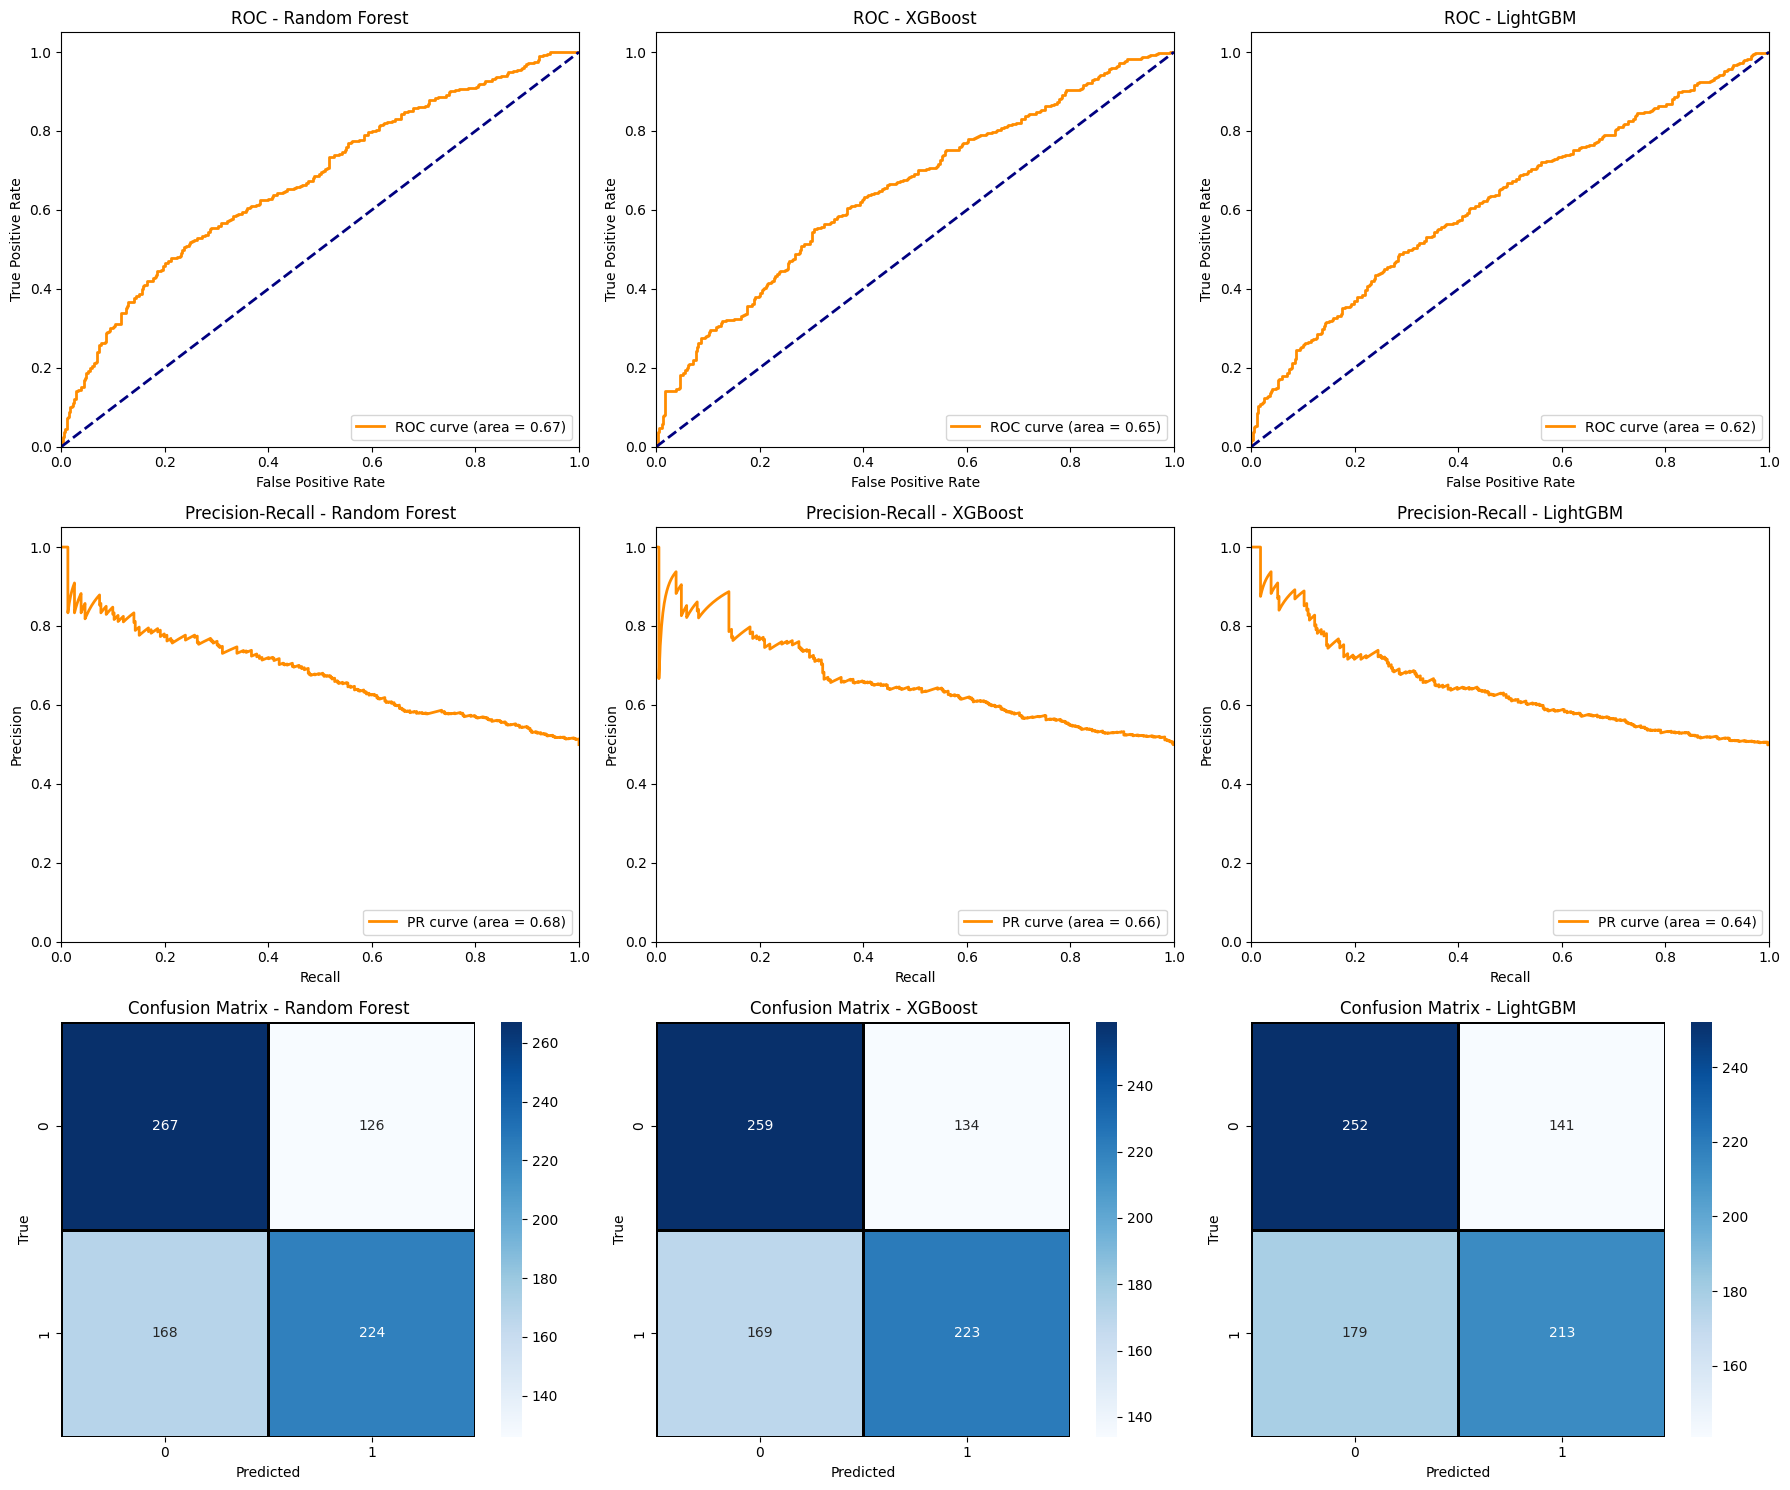

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6254777070063694, 'Precision': 0.64, 'Recall': 0.5714285714285714, 'F1 Score': 0.6037735849056605, 'ROC AUC': 0.673235706496339}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6140127388535032, 'Precision': 0.6246498599439776, 'Recall': 0.5688775510204082, 'F1 Score': 0.595460614152203, 'ROC AUC': 0.6509451108687749}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.5923566878980892, 'Precision': 0.6016949152542372, 'Recall': 0.5433673469387755, 'F1 Score': 0.5710455764075066, 'ROC AUC': 0.6247208807186997}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.5923566878980892,
 'Precision': 0.6016949152542372,
 'Recall': 0.5433673469387755,
 'F1 Score': 0.5710455764075066,
 'ROC AUC': 0.6247208807186997}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6255


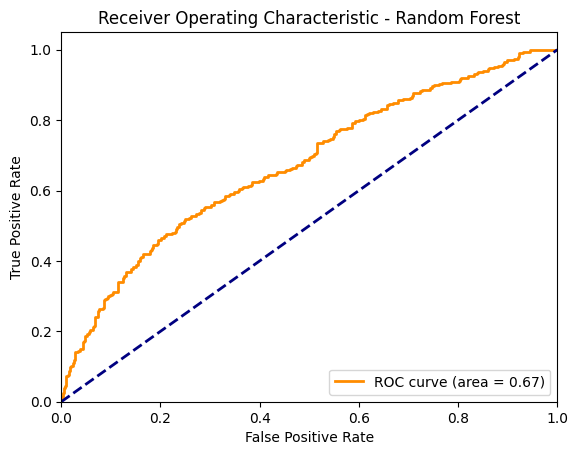

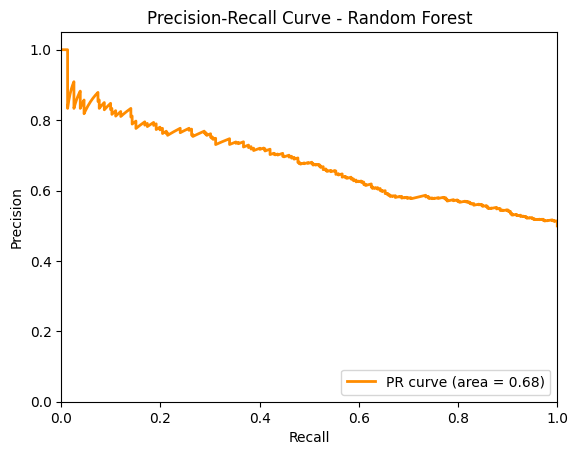

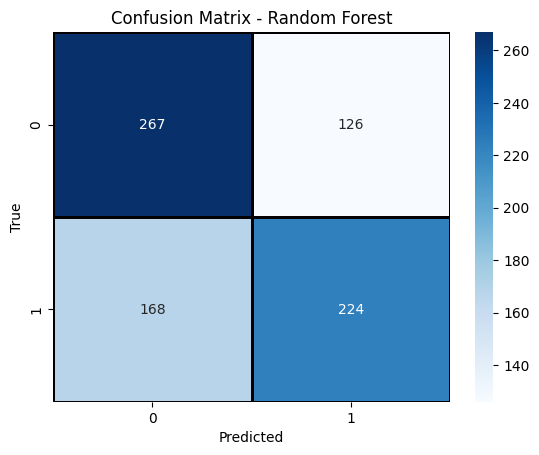

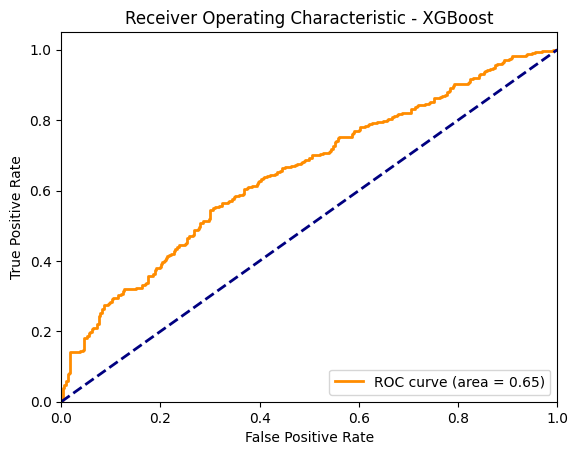

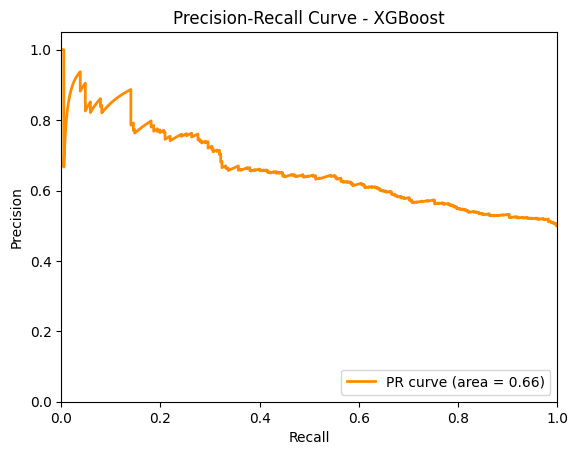

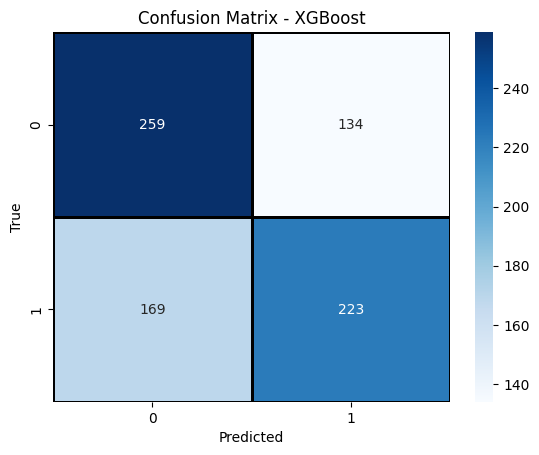

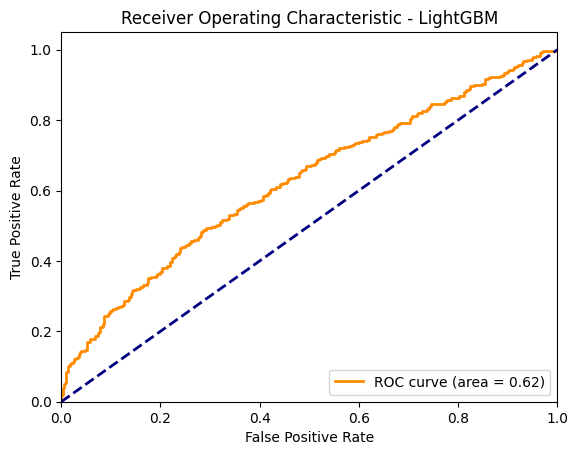

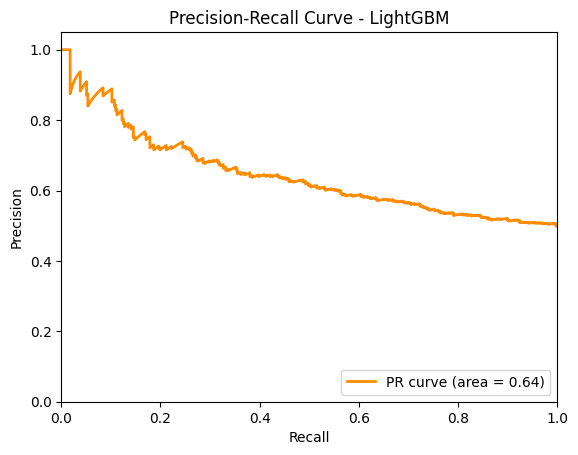

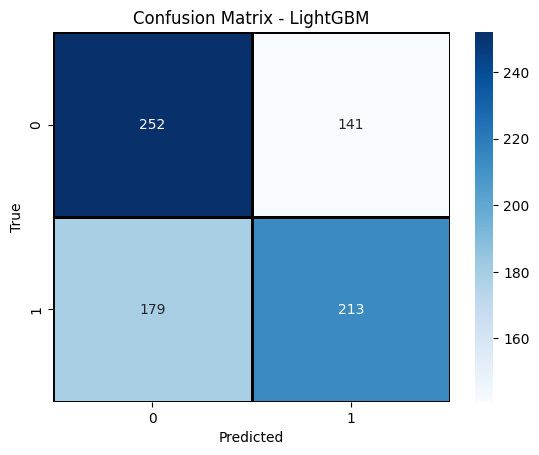

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

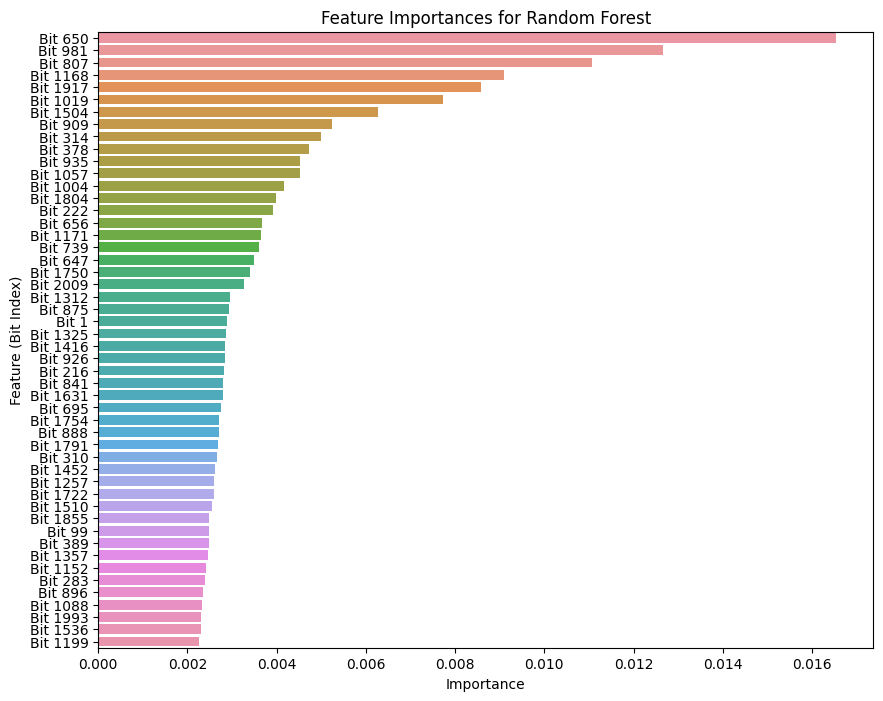

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
